# Deep Progressive Image Compression

## Overview

his Python notebook compares the effectiveness of various existing neural network architectures when 
applied to the task of progressive image compression. The aim of this notebook is to find architectures that yield better compression for a given perceptual quality than standard image compression codecs such as JPEG. All neural networks are implemented using the PyTorch framework.

Requirements:
--------------
- Pytorch 0.4.1
- PIL 
- Torchvison
- ScikitImage

**Imports**

In [1]:
import os
import torch
%matplotlib inline
import evaluate as ev
import subprocess as sub
import networks as img_auto
from img_tools import EvaluationImageDataLoaders, TrainImageDataLoaders

**Helper Functions**

In [2]:
"""
Function : run_cmd
    
    runs a python script from within python and prints stdout to screen in real-time
    
    Args:
        cmd (string) : command to run as subprocess
        
    Ref: https://stackoverflow.com/questions/17411966/
"""

def run_cmd(cmd):
    
    # create subprocess
    proc = sub.Popen(cmd, stdout=sub.PIPE, universal_newlines=True)
    
    # read output line for line
    while proc.poll() is None:
        
        opt = proc.stdout.readline()
        print(opt)
    
    # print rest of opt
    print(proc.stdout.read()) 
    
    return    

## Progressive Autoencoder Models

## Preprocess Data

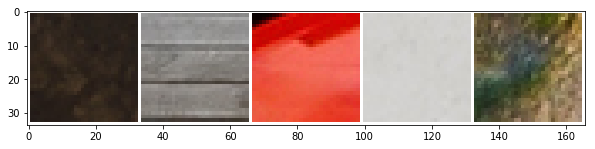

In [3]:
train_img_dl = TrainImageDataLoaders(
    b_s = 5, 
    p_s = 32, 
    root_dir='~/Pictures/Clic/Professional'
)
train_img_dl.display_data('train')

## FeedForwardAR

Feed-forward autoencoder additive reconstruction network from 'Variable Rate Image Compression with Recurrent Neural Networks' by G. Toderici et al (https://arxiv.org/pdf/1511.06085.pdf).

<img src="files/model_diag/ff_auto.png">

**Train Model**

In [5]:
# train script cmd
cmd = [
    'python'      , 'train.py',
    '--sys'       , 'FForward',
    '--epochs'    , '15000',
    '--learn_rate', '0.0001',
    '--gamma'     , '0.5',
    '--log'       , './logs/ff16',
    '--trainDir'  , '~/Pictures/Clic/Professional',
    '--save_loc'  , './saved_models/ff',
    '--patch_size', '32',
    '--batch_size', '32',
    '--itrs'      , '16',
    '--bits'      , '128',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**Load Model**

In [2]:
# def model
FForward = img_auto.FForwardAutoencoder(
    itrs = 16, 
    p_s  = 32, 
    b_n  = 128
)

# load trained parameters
FForward.load_state_dict(torch.load('./saved_models/FForward/FForward.pt'))

#### Model Results
**Evaluate Model on Validation Data**

In [8]:
ImgDir = '~/Pictures/Clic/Professional/valid'

# create an eval instance
eval_model = ev.EvaluateModel(
    ImgDir, 
    FForward
)

***Compare Validation Patches***

SSIM : 0.8683630495213017
PSNR : 30.301787116938556


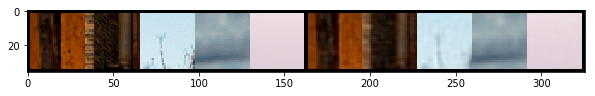

In [6]:
# comp patches
eval_model.compare_patches(
    itrs =  16
)

***Validation Image Quality vs Encoding Iterations***

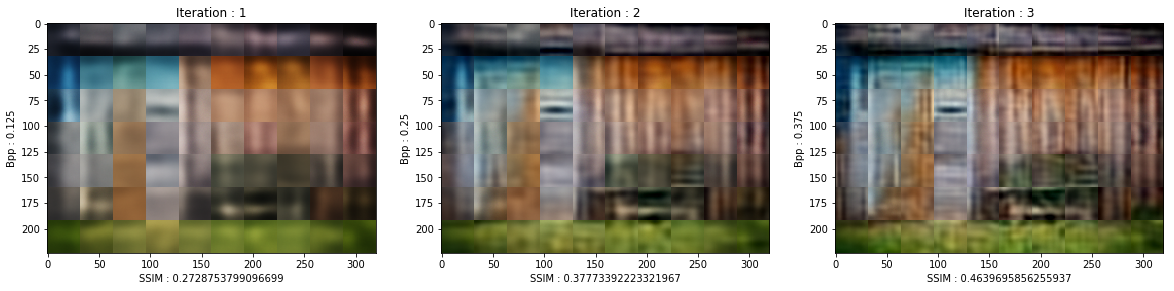

In [7]:
# Show Image 
eval_model.progressive_imshow(
    metric='SSIM',
    itrs=3,
    # widget=True
)

## ConvAR

Progressive convolutional autoencoder image compression system based on the Additive Reconstruction (AR) network proposed in 'Variable Rate Image Compression with Recurrent Neural Networks' by G. Toderici et al. (https://arxiv.org/pdf/1511.06085.pdf) and Appendix C.3 Table 6 of 'Learning to Inpaint' by M. Baig et al (https://arxiv.org/pdf/1709.08855.pdf).

<img src="files/model_diag/conv_ar.png">

**Train Model**

In [3]:
# train script cmd
cmd = [
    'python'      , 'train.py',
    '--sys'       , 'Conv',
    '--epochs'    , '15000',
    '--learn_rate', '0.0001',
    '--gamma'     , '0.5',
    '--log'       , './logs/Conv',
    '--trainDir'  , '~/Pictures/Clic/Professional',
    '--save_loc'  , './saved_models/Conv',
    '--patch_size', '32',
    '--batch_size', '32',
    '--itrs'      , '1',
    '--bits'      , '128',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**Load Trained Model**

In [5]:
# def model
Conv = img_auto.ConvAutoencoder(
    itrs = 16, 
    p_s  = 32,
    b_n  = 128
)

# load trained parameters
Conv.load_state_dict(torch.load('./saved_models/Conv/Conv.pt'))

#### Model Results
***Evaluate Model on Validation Data***

In [17]:
# create an evaluation instance
eval_model = ev.EvaluateModel(
    img_dir='~/Pictures/Clic/Professional/valid', 
    model=Conv
)

***Compare Validation Patches***

SSIM : 0.9454255092158398
PSNR : 33.73822026184735


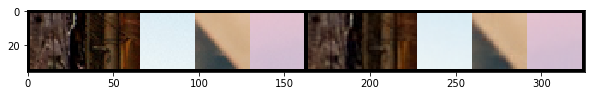

In [10]:
# comp patches
eval_model.compare_patches(
    itrs =  16
)

***Validation Image Quality vs Encoder Iterations***

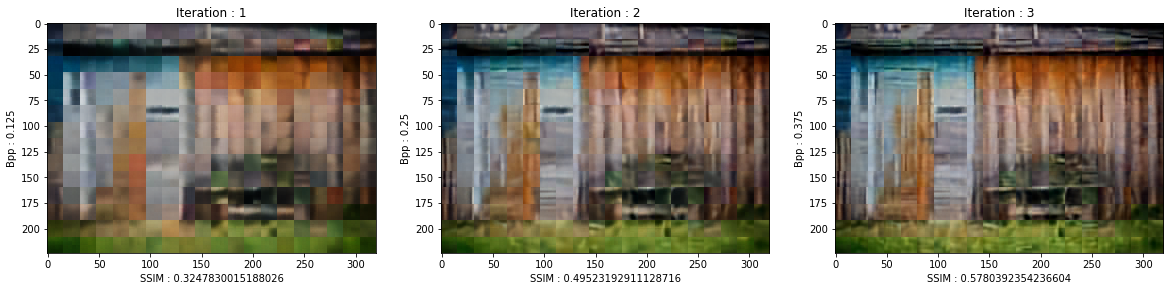

In [11]:
# Display Image Compressions 
eval_model.progressive_imshow(
    metric='SSIM',
    itrs=3,
    # widget=True
)

## ConvGRU-OSR

Implimentation of Google's c0onvolutional gated recurrent unit one-shot reconstruction image compression system (without entropy coding network). Model described in 'Full Resolution Image Compression' by George Toderici et al (https://arxiv.org/pdf/1608.05148.pdf).

<img src="files/model_diag/conv_gru_osr.png">

**Train Model 16 Iterations**

In [3]:
# train script cmd
cmd = [
    'python'      , 'train.py',
    '--sys'       , 'ConvRNN',
    '--epochs'    , '15000',
    '--learn_rate', '0.0001',
    '--gamma'     , '0.5',
    '--log'       , './logs/ConvRNN',
    '--trainDir'  , '~/Pictures/Clic/Professional',
    '--save_loc'  , './saved_models/ConvRNN',
    '--patch_size', '32',
    '--batch_size', '32',
    '--itrs'      , '3',
    '--bits'      , '128',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

**Load Trained Model**

In [3]:
# define compression system
ConvRNN = img_auto.ConvRnnAutoencoder(
    itrs = 16, 
    p_s  = 32, 
    b_n  = 128,
)

# load model parameters
ConvRNN.load_state_dict(
    torch.load('./saved_models/ConvRNN/ConvRNN.pt')
)

#### Model Results
**Evaluate Model on Validation Data**

In [7]:
# compare models on validation set
ImgDir = '~/Pictures/Clic/Professional/valid'

# create an eval instance
eval_model = ev.EvaluateModel(
    ImgDir, 
    ConvRNN
)

***Compare Evaluation Patches***

SSIM : 0.9845985398027158
PSNR : 36.454427780626965


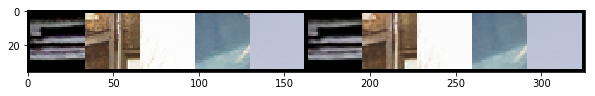

In [16]:
# comp patches
eval_model.compare_patches(
    itrs =  16
)

***Validation Image Quality vs Encoding Iterations***

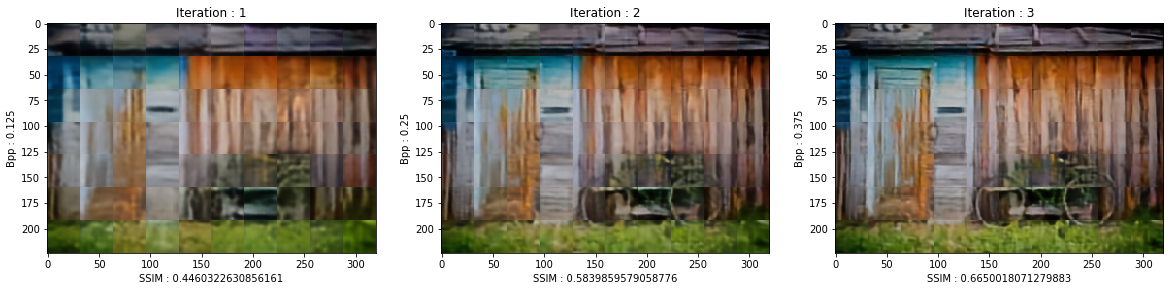

In [17]:
# Display Image Compressions 
eval_model.progressive_imshow(
    metric='SSIM',
    itrs=3
)

## Network Comparison

In [6]:
# model comparison object
cm = ev.CompareModels(
    img_dir="~/Pictures/Clic/Professional", 
    models=[FForward, Conv, ConvRNN],
    codecs=['JPEG', 'JPEG (Progressive)']
)

**Progressive Image Rconstructions 3 Iterations**

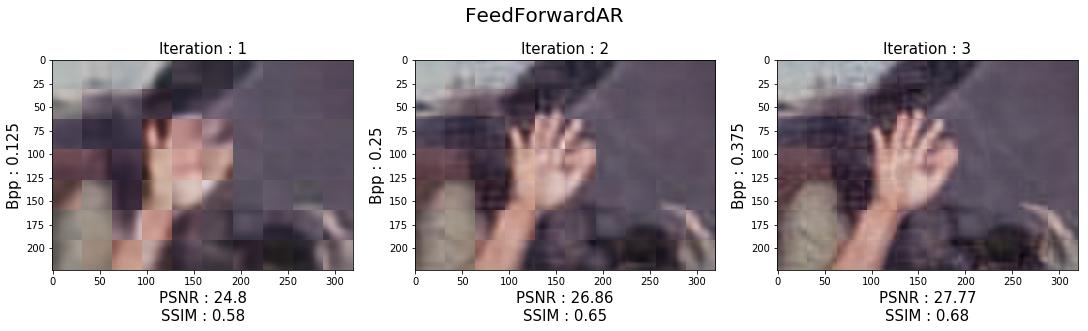

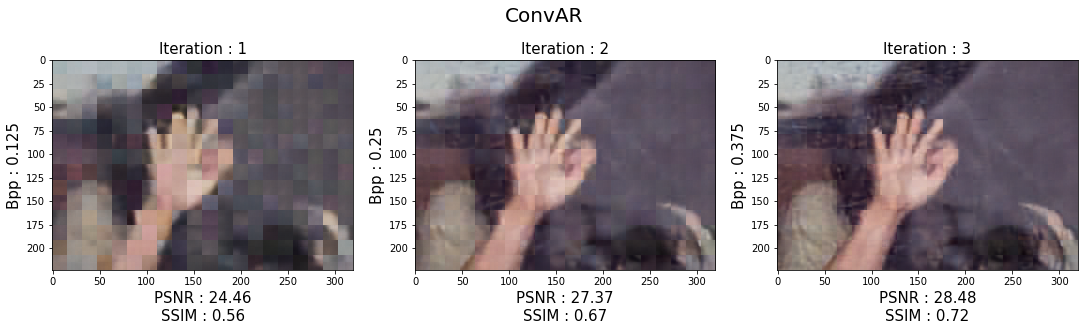

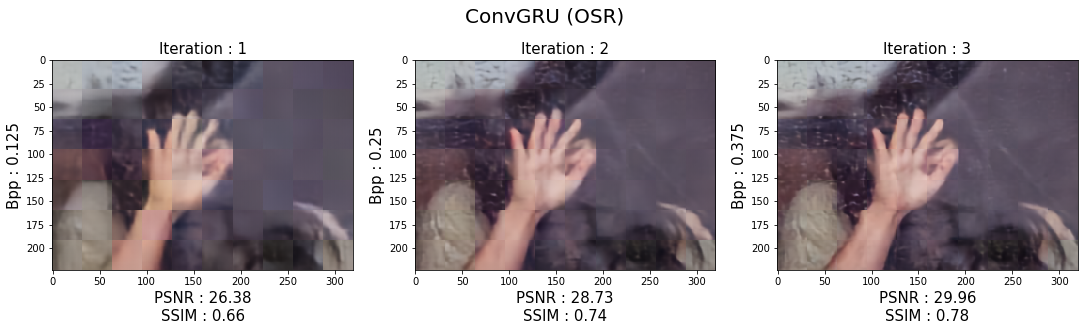

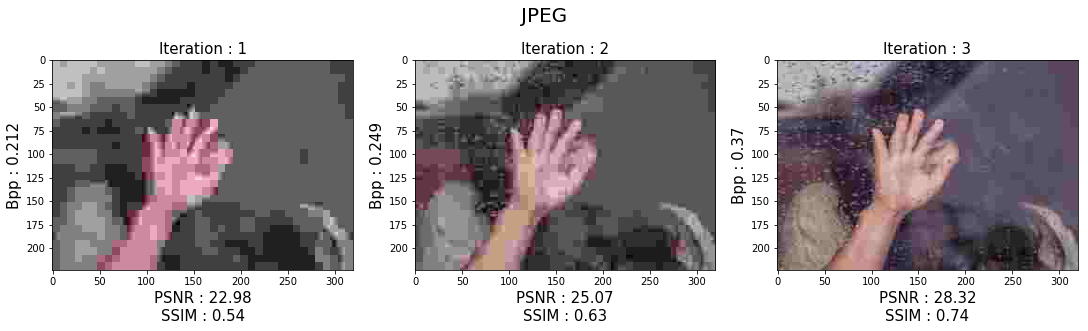

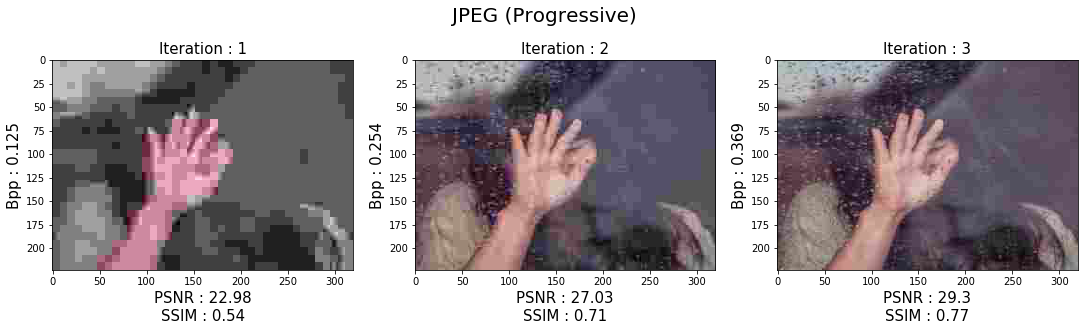

In [9]:
cm.display_compressed_images(dataset="test", itrs=3)

**SSIM Rate-Distortion Curve**

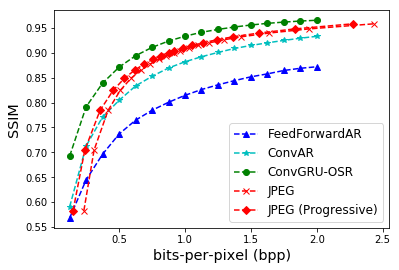

In [7]:
# display SSIM compression curve
cm.display_compression_curve(metric="SSIM", dataset="test")

**SSIM Area-Under-Curve**

In [8]:
# Calculate AUC data
cm.display_auc(metric="PSNR", dataset="test", bpp_min=0.125, bpp_max=2.0)

Displaying AUC:

Deep Compression Models
FeedForwardAR : 51.691009820300394
ConvAR : 55.58181573633114
ConvGRU (OSR) : 61.42325989346561

Standard Codecs
JPEG : 56.6202109898627
JPEG (Progressive) : 59.28950172583455


**PSNR Rate-Distortion Curve**

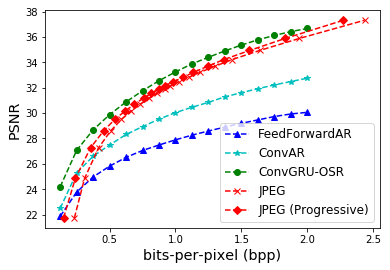

In [8]:
# display PSNR compression curve
cm.display_compression_curve(metric="PSNR", dataset="test")

**PSNR Area-Under-Curve**

In [10]:
cm.display_auc(metric="PSNR", dataset="test")

Displaying AUC:

Deep Compression Models
FeedForwardAR : 51.691009820300394
ConvAR : 55.58181573633114
ConvGRU (OSR) : 61.42325989346561

Standard Codecs
JPEG : 56.6202109898627
JPEG (Progressive) : 59.28950172583455


# END ...